In [1]:
# results directories:
# /home/jxm3/random/interpretable-autoprompting/results/intermediate_results_from_chandan/anli
# /home/jxm3/random/interpretable-autoprompting/results/intermediate_results_from_chandan/math

%load_ext autoreload
%autoreload 2

In [2]:
import analyze_utils

In [3]:
dir_single_query = '/home/jxm3/random/interpretable-autoprompting/results/intermediate_results_from_chandan_3/anli'
r = analyze_utils.load_results_and_cache_prefix_json(dir_single_query, save_file='r.pkl')

r['use_single_query'] = r['single_query']
r['final_answer_pos_initial_token']
r = analyze_utils.postprocess_results(r)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:03<00:00, 58.51it/s]


In [4]:
r.apply(lambda row: '_'.join(map(str, row[['checkpoint', 'task_name', 'use_single_query', 'n_shots', 'do_reranking']])), axis=1).value_counts()

EleutherAI/gpt-neo-2.7B_task1191_food_veg_nonveg_Avg suffix_5_0              128
EleutherAI/gpt-j-6B_task1509_evalution_antonyms_Avg suffix_1_0               128
EleutherAI/gpt-j-6B_task088_identify_typo_verification_Single-query_1_1      128
EleutherAI/gpt-j-6B_task088_identify_typo_verification_Avg suffix_5_0        128
EleutherAI/gpt-neo-2.7B_task107_splash_question_to_sql_Avg suffix_1_0        128
                                                                            ... 
EleutherAI/gpt-j-6B_task088_identify_typo_verification_Single-query_1_0      128
EleutherAI/gpt-neo-2.7B_task088_identify_typo_verification_Avg suffix_5_0    128
EleutherAI/gpt-j-6B_task1147_country_currency_Single-query_5_0               128
EleutherAI/gpt-j-6B_task088_identify_typo_verification_Avg suffix_1_1        128
gpt2-xl_task1146_country_capital_Avg suffix_1_1                              128
Length: 184, dtype: int64

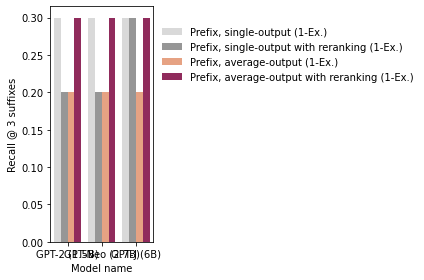

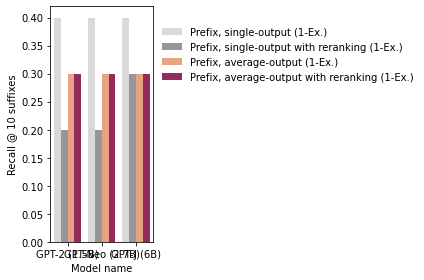

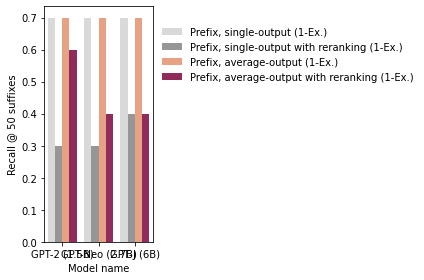

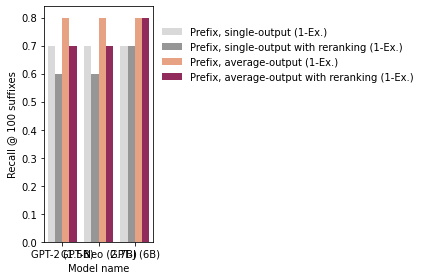

In [5]:
from typing import Dict

# rt = r[r.task_name.isin(['add_two', 'multiply_two', 'subtract_two'])]
import matplotlib.pyplot as plt
rt = r

def make_legend__prefix(table_row: Dict) -> str:
    single_query_str = {
        0: 'average',
        1: 'single'
    }[table_row['single_query']]
    rerank_str = {
        0: '',
        1: ' with reranking'
    }[table_row['do_reranking']]
    
    return 'Prefix, ' + single_query_str + '-output' + rerank_str + f' ({table_row["n_shots"]}-Ex.)'


for metric_key in [#'final_answer_pos_initial_token',
                   f'Recall @ {3} suffixes',
                   f'Recall @ {10} suffixes', 
                   f'Recall @ {50} suffixes', 
                   f'Recall @ {100} suffixes', 
                   ]:
    table = (rt[rt['n_shots'] == 1]
        # mean over templates, task_name)
        .groupby(['checkpoint', 'n_shots', 'do_reranking', 'single_query'])[[metric_key]]
        .mean()
        .reset_index()
    )
    table['legend'] = table.apply(make_legend__prefix, axis=1)
    analyze_utils.plot_tab(table, metric_key=metric_key, title='ANLI datasets', add_legend=False)

    # if metric_key == 'final_answer_pos_initial_token':
      # plt.savefig('../results/prompt_gen/math_barplot.pdf', bbox_inches='tight')
    plt.show()


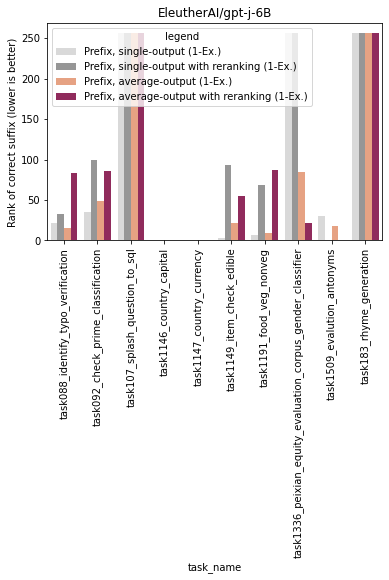

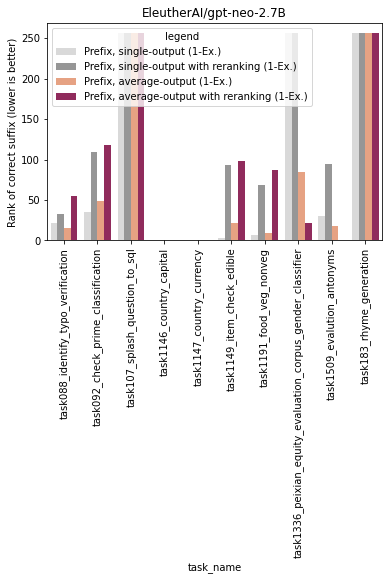

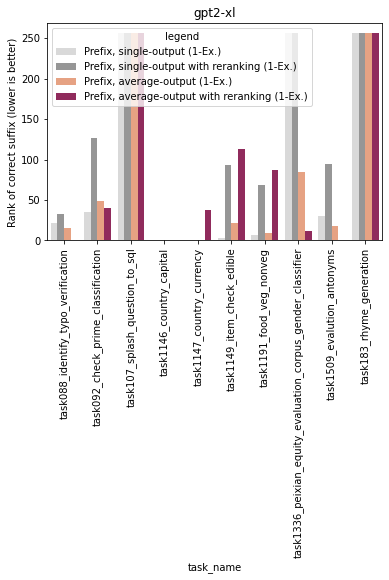

In [13]:
# cols_to_view = r_single_query.columns # cols_to_view
import pandas as pd
import seaborn as sns

key_vars = ['checkpoint', 'n_shots', 'single_query', 'do_reranking', 'task_name']
cols_to_view = [col for col in r.columns if col.startswith('final')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    rg = r.groupby(key_vars)[cols_to_view].mean().round(2)
    # display(rg[rg['final_answer_found'] < 1.0])
    # display(rg)
# r.groupby(['template_num_init_string', 'use_single_query']).median().round(2)['final_model_queries'] # look at templates

for checkpoint in rg.reset_index().checkpoint.unique():
    rp = rg.reset_index().fillna(256)
    # checkpoint = 'EleutherAI/gpt-j-6B'
    metric_key = 'final_answer_pos_initial_token'

    rp = rp[(rp['checkpoint'] == checkpoint) & (rp['n_shots'] == 1)]
    rp['legend'] = rp.apply(make_legend__prefix, axis=1)
    hue_order = analyze_utils.get_hue_order(rp['legend'])
    plt.title(checkpoint)
    sns.barplot(x='task_name', y=metric_key, hue_order=hue_order,
                hue='legend', data=rp, palette=analyze_utils.COLORS)  # data=tab[tab['n_shots'] == 1])
    plt.xticks(rotation='vertical')
    plt.ylabel(analyze_utils.YLABS.get(metric_key, metric_key))
    plt.show()

In [7]:
def get_r_subset(
    checkpoint: str,
    task_name: str, 
    n_shots: int, 
    single_query: bool,
    do_reranking: bool,
) -> pd.DataFrame:
    return r[
        (r['checkpoint'] == checkpoint) &
        (r['task_name'] == task_name) &
        (r['n_shots'] == n_shots) &
        (r['single_query'] == single_query) &
        (r['do_reranking'] == do_reranking)
    ]

t1 = get_r_subset('EleutherAI/gpt-j-6B', 'task092_check_prime_classification', 1, False, True)
print(t1['final_answer_pos_initial_token'].unique())

t2 = get_r_subset('EleutherAI/gpt-j-6B', 'task092_check_prime_classification', 1, True, False)
print(t2['final_answer_pos_initial_token'].unique())

[86.]
[35.]


In [8]:
t1['accs']

0      0.525538
1      0.510923
2      0.501077
3      0.500308
4      0.499538
         ...   
123    0.000000
124    0.000000
125    0.000000
126    0.000000
127    0.000000
Name: accs, Length: 128, dtype: float64

In [9]:
t2.columns

Index(['batch_size', 'max_dset_size', 'seed', 'n_epochs', 'max_digit',
       'template_num_init_string', 'template_num_task_phrasing', 'save_dir',
       'epoch_save_interval', 'lr', 'mlm_num_candidates', 'mlm_name',
       'do_reranking', 'task_name', 'n_shots', 'single_query', 'use_cache',
       'checkpoint', 'prefixes', 'prefixes__check_answer_func',
       'json_filename', 'final_answer_full', 'final_answer_pos_initial_token',
       'index', 'losses', 'accs', 'use_single_query', 'final_model_queries',
       'final_answer_added', 'final_num_suffixes_checked',
       'final_answer_depth', 'final_answer_found', 'Recall @ 3 suffixes',
       'Recall @ 5 suffixes', 'Recall @ 10 suffixes', 'Recall @ 15 suffixes',
       'Recall @ 20 suffixes', 'Recall @ 25 suffixes', 'Recall @ 30 suffixes',
       'Recall @ 40 suffixes', 'Recall @ 50 suffixes', 'Recall @ 75 suffixes',
       'Recall @ 100 suffixes', 'Recall @ 150 suffixes',
       'Recall @ 200 suffixes', 'reciprocal_rank', 'reciproc

In [10]:
t1.iloc[23]['prefixes']

'The answer takes the input number and returns whether it is suitable.'

In [11]:
t1[t1['prefixes__check_answer_func']][['prefixes']], t1[t1['prefixes__check_answer_func']][['prefixes', 'accs', 'losses']]

(                                             prefixes
 86  The answer takes the input number and returns ...,
                                              prefixes      accs   losses
 86  The answer takes the input number and returns ...  0.007385  0.25929)

In [12]:
t2[t2['prefixes__check_answer_func']][['prefixes']], t2[t2['prefixes__check_answer_func']][['prefixes']].values

(                                             prefixes
 35  The answer takes the input number and returns ...,
 array([['The answer takes the input number and returns whether it is prime.']],
       dtype=object))